<a href="https://colab.research.google.com/github/PawanSth/AI-Lab-Pawan-/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

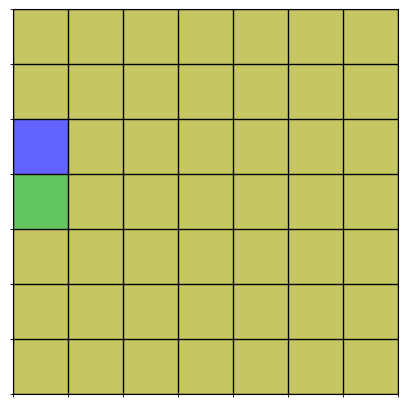

In [25]:
#Reflex based agent
 #(Red	Tile still dirty,
 #Green	Tile clean (agent hasn’t been here)
 #Yellow	Tile clean & visited by agent
 #Blue	The agent’s current cell)


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
from IPython.display import HTML

# Simulation parameters
GRID_SIZE    = 7
INTERVAL_MS  = 200   # milliseconds per frame
NUM_EPISODES = 3     # how many times to respawn & run

# Colors for visualization (RGB)
COLORS = {
    'dirty':   (1.00, 0.39, 0.39),
    'clean':   (0.39, 0.78, 0.39),
    'agent':   (0.39, 0.39, 1.00),
    'visited': (0.78, 0.78, 0.39),
}

class RandomWalkVacuumAgent:
    def __init__(self, size):
        self.size = size

    def reset(self):
        # New random dirt layout + random spawn
        self.grid    = np.random.randint(0, 2, (self.size, self.size))
        self.pos     = (random.randrange(self.size), random.randrange(self.size))
        self.visited = {self.pos}

    def neighbors(self, x, y):
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                yield (nx, ny)

    def step(self):
        x, y = self.pos

        # 1) clean if dirty
        if self.grid[x, y] == 0:
            self.grid[x, y] = 1
        else:
            # 2) look for adjacent dirty
            adj = list(self.neighbors(x, y))
            dirty_adj = [p for p in adj if self.grid[p] == 0]
            if dirty_adj:
                nxt = random.choice(dirty_adj)
            else:
                # 3) then look for adjacent unvisited
                unvisited_adj = [p for p in adj if p not in self.visited]
                if unvisited_adj:
                    nxt = random.choice(unvisited_adj)
                else:
                    # 4) otherwise move randomly to any adjacent to keep exploring
                    nxt = random.choice(adj)

            self.pos = nxt
            self.visited.add(nxt)

        return True

    def run_episode(self):
        frames = []
        # keep stepping until **all** cells are clean and visited
        total_cells = self.size * self.size
        while not (np.all(self.grid==1) and len(self.visited)==total_cells):
            # record a frame BEFORE the step so you see the clean action
            frame = np.zeros((self.size, self.size, 3))
            for i in range(self.size):
                for j in range(self.size):
                    if (i, j) == self.pos:
                        frame[i, j] = COLORS['agent']
                    elif self.grid[i, j] == 0:
                        frame[i, j] = COLORS['dirty']
                    elif (i, j) in self.visited:
                        frame[i, j] = COLORS['visited']
                    else:
                        frame[i, j] = COLORS['clean']
            frames.append(frame)
            self.step()
        return frames

# Run multiple episodes and gather frames
agent = RandomWalkVacuumAgent(GRID_SIZE)
all_frames = []
for _ in range(NUM_EPISODES):
    agent.reset()
    all_frames.extend(agent.run_episode())

# Plot setup with clear grid lines
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(all_frames[0], interpolation='nearest')
ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(GRID_SIZE - 0.5, -0.5)

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=all_frames,
    interval=INTERVAL_MS, blit=True
)

HTML(ani.to_jshtml())


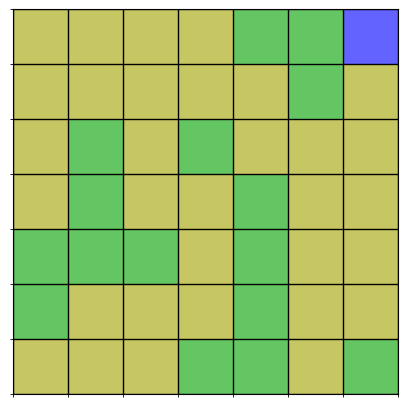

In [26]:
#Goal based agent
 #(Red	Tile still dirty,
 #Green	Tile clean (agent hasn’t been here)
 #Yellow	Tile clean & visited by agent
 #Blue	The agent’s current cell)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
from collections import deque
from IPython.display import HTML

# Simulation parameters
GRID_SIZE    = 7
INTERVAL_MS  = 200
NUM_EPISODES = 3

COLORS = {
    'dirty':   (1.00, 0.39, 0.39),
    'clean':   (0.39, 0.78, 0.39),
    'visited': (0.78, 0.78, 0.39),
    'agent':   (0.39, 0.39, 1.00),
}

class GoalBasedVacuumAgent:
    def __init__(self, size):
        self.size = size

    def reset(self):
        self.grid    = np.random.randint(0, 2, (self.size, self.size))
        self.pos     = (random.randrange(self.size), random.randrange(self.size))
        self.visited = {self.pos}

    def neighbors(self, x, y):
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                yield (nx, ny)

    def find_nearest_dirty(self):
        """BFS to find path to nearest dirty tile"""
        start = self.pos
        queue = deque([(start, [])])
        seen = {start}
        while queue:
            (x,y), path = queue.popleft()
            if self.grid[x,y] == 0:
                return path  # path of positions to reach this dirty cell
            for nb in self.neighbors(x, y):
                if nb not in seen:
                    seen.add(nb)
                    queue.append((nb, path + [nb]))
        return []

    def step(self):
        x, y = self.pos
        # Clean if dirty
        if self.grid[x,y] == 0:
            self.grid[x,y] = 1
        else:
            path = self.find_nearest_dirty()
            if not path:
                return False  # done
            # take one step along the path
            next_pos = path[0]
            self.pos = next_pos
            self.visited.add(next_pos)
        return True

    def run_episode(self):
        frames = []
        while True:
            # record frame
            frame = np.zeros((self.size, self.size, 3))
            for i in range(self.size):
                for j in range(self.size):
                    if (i,j) == self.pos:
                        frame[i,j] = COLORS['agent']
                    elif self.grid[i,j] == 0:
                        frame[i,j] = COLORS['dirty']
                    elif (i,j) in self.visited:
                        frame[i,j] = COLORS['visited']
                    else:
                        frame[i,j] = COLORS['clean']
            frames.append(frame)
            if not self.step():
                break
        return frames

# run and animate
agent = GoalBasedVacuumAgent(GRID_SIZE)
all_frames = []
for _ in range(NUM_EPISODES):
    agent.reset()
    all_frames.extend(agent.run_episode())

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(all_frames[0], interpolation='nearest')
ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(GRID_SIZE - 0.5, -0.5)

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=all_frames,
    interval=INTERVAL_MS, blit=True
)
HTML(ani.to_jshtml())


In [37]:
#Utility based agent
 #(Red	Tile still dirty,
 #Green	Tile clean (agent hasn’t been here)
 #Yellow	Tile clean & visited by agent
 #Blue	The agent’s current cell
 #purple = Target)


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import heapq
from IPython.display import HTML

# Simulation parameters
GRID_SIZE    = 7
INTERVAL_MS  = 200   # milliseconds per frame
NUM_EPISODES = 3     # how many times to respawn & run

# Colors for visualization (RGB)
COLORS = {
    'dirty':   (1.00, 0.39, 0.39),  # red
    'clean':   (0.39, 0.78, 0.39),  # green (clean & not yet visited)
    'visited': (0.78, 0.78, 0.39),  # yellow (clean & visited)
    'agent':   (0.39, 0.39, 1.00),  # blue
    'target':  (0.78, 0.39, 0.78),  # purple (current path target)
}

class UtilityBasedVacuumAgent:
    def __init__(self, size):
        self.size = size

    def reset(self):
        # random dirt map + spawn
        self.grid    = np.random.randint(0, 2, (self.size, self.size))
        self.pos     = (random.randrange(self.size), random.randrange(self.size))
        self.visited = {self.pos}
        self.target  = None
        self.path    = []

    def neighbors(self, x, y):
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                yield (nx, ny)

    def find_closest_dirty(self):
        # BFS to nearest dirty tile
        from collections import deque
        queue = deque([(self.pos, [])])
        seen = {self.pos}
        while queue:
            (x, y), path = queue.popleft()
            if self.grid[x, y] == 0:
                return path
            for nb in self.neighbors(x, y):
                if nb not in seen:
                    seen.add(nb)
                    queue.append((nb, path + [nb]))
        return []

    def step(self):
        x, y = self.pos
        # 1: clean if dirty
        if self.grid[x, y] == 0:
            self.grid[x, y] = 1
            self.visited.add((x, y))
            self.target = None
            self.path   = []
            return True
        # 2: follow current path
        if self.path:
            self.pos = self.path.pop(0)
            self.visited.add(self.pos)
            return True
        # 3: plan to nearest dirty
        new_path = self.find_closest_dirty()
        if new_path:
            self.path   = new_path
            self.target = new_path[-1]
            return self.step()
        # 4: no dirty left, stop
        return False

    def run_episode(self):
        frames = []
        # run until no dirty cells remain
        while np.any(self.grid == 0):
            canvas = np.zeros((self.size, self.size, 3))
            for i in range(self.size):
                for j in range(self.size):
                    if (i,j) == self.pos:
                        canvas[i,j] = COLORS['agent']
                    elif self.grid[i,j] == 0:
                        canvas[i,j] = COLORS['dirty']
                    elif (i,j) in self.visited:
                        canvas[i,j] = COLORS['visited']
                    else:
                        canvas[i,j] = COLORS['clean']
                    if self.target == (i,j):
                        canvas[i,j] = COLORS['target']
            frames.append(canvas)
            self.step()
        # final all-clean frame
        final = np.zeros((self.size, self.size, 3))
        final[:,:,:] = COLORS['clean']
        frames.append(final)
        return frames

# collect frames over multiple random starts
agent      = UtilityBasedVacuumAgent(GRID_SIZE)
all_frames = []
for _ in range(NUM_EPISODES):
    agent.reset()
    all_frames.extend(agent.run_episode())

# set up the plot
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(all_frames[0], interpolation='nearest')
ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim(-0.5, GRID_SIZE-0.5)
ax.set_ylim(GRID_SIZE-0.5, -0.5)

# legend
from matplotlib.patches import Patch
legend_elems = [
    Patch(facecolor=COLORS['dirty'], label='Dirty'),
    Patch(facecolor=COLORS['clean'], label='Clean'),
    Patch(facecolor=COLORS['visited'], label='Visited'),
    Patch(facecolor=COLORS['agent'], label='Agent'),
    Patch(facecolor=COLORS['target'], label='Target'),
]
ax.legend(handles=legend_elems, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

# animation
def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=all_frames, interval=INTERVAL_MS, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())
